# Prédiction du risque de crédit à l’aide de modèles de Machine Learning

Ce notebook présente l’implémentation et la comparaison de trois modèles de classification :
**MLP (Multi-Layer Perceptron)**, **KNN (K-Nearest Neighbors)** et **SVM (Support Vector Machine)**.
L’objectif est de détecter les cas de défaut de paiement à partir de données bancaires
déséquilibrées.


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt


In [ ]:
df = pd.read_csv("df_cleaned_engineered.csv")

X = df.drop(columns=["TARGET"])
y = df["TARGET"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights :", class_weight_dict)


Class weights : {0: np.float64(0.6420055029043106), 1: np.float64(2.2604951560818085)}


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Modèle MLP (Multi-Layer Perceptron)

Le MLP est un réseau de neurones artificiels capable de modéliser des relations non linéaires
entre les variables d’entrée.

Le modèle a été implémenté à l’aide de Keras.  
Une recherche d’hyperparamètres a été effectuée avec Keras Tuner afin d’optimiser :
- le nombre de couches cachées,
- le nombre de neurones par couche,
- la fonction d’activation (ReLU ou tanh),
- l’optimiseur.

Le déséquilibre des classes est pris en compte lors de l’entraînement grâce à l’utilisation
de poids de classes, ce qui permet de pénaliser davantage les erreurs sur la classe minoritaire
(défaut).


In [ ]:
def build_model(hp):
    model = Sequential()

    activation = hp.Choice("activation", ["relu", "tanh"])

    # Nombre de couches cachées
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(Dense(
            units=hp.Choice(f"units_{i}", [16, 32, 64, 128]),
            activation=activation
        ))
        model.add(BatchNormalization())
        model.add(Dropout(
            hp.Choice(f"dropout_{i}", [0.0, 0.2, 0.3])
        ))

    # Couche de sortie
    model.add(Dense(1, activation="sigmoid"))

    # Choix de l'optimizer
    optimizer_name = hp.Choice("optimizer", ["adam", "rmsprop"])
    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = RMSprop(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_auc",
    max_trials=30,
    executions_per_trial=1,
    directory="kt_dir",
    project_name="mlp_credit_default"
)


In [ ]:
early_stop = EarlyStopping(
    monitor="val_auc",
    patience=5,
    restore_best_weights=True
)


In [ ]:
tuner.search(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Trial 30 Complete [00h 00m 41s]
val_auc: 0.7913440465927124

Best val_auc So Far: 0.795460045337677
Total elapsed time: 00h 24m 17s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 128)              │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 128)              │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
y_prob = best_model.predict(X_test_scaled).ravel()
y_pred = (y_prob > 0.3).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC :", roc_auc_score(y_test, y_prob))


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.37      0.53      7009
           1       0.29      0.90      0.44      1991

    accuracy                           0.49      9000
   macro avg       0.61      0.63      0.48      9000
weighted avg       0.78      0.49      0.51      9000

ROC-AUC : 0.7721012210819712


In [ ]:
early_stop = EarlyStopping(
    monitor="val_auc",
    patience=5,
    restore_best_weights=True
)

history = best_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - auc: 0.7819 - loss: 0.5588 - recall: 0.6276 - val_auc: 0.7953 - val_loss: 0.5428 - val_recall: 0.6240
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - auc: 0.7818 - loss: 0.5578 - recall: 0.6226 - val_auc: 0.7949 - val_loss: 0.5438 - val_recall: 0.6270
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - auc: 0.7822 - loss: 0.5573 - recall: 0.6383 - val_auc: 0.7952 - val_loss: 0.5402 - val_recall: 0.6240
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc: 0.7811 - loss: 0.5579 - recall: 0.6374 - val_auc: 0.7945 - val_loss: 0.5435 - val_recall: 0.6230
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc: 0.7841 - loss: 0.5592 - recall: 0.6383 - val_auc: 0.7950 - val_loss: 0.5434 - val_recall: 0.6301
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - auc: 0.7831 - loss: 0.5579 - recall: 0.6398 - val_auc: 0.7950 - val_loss: 0.5420 - val_recall: 0.6281


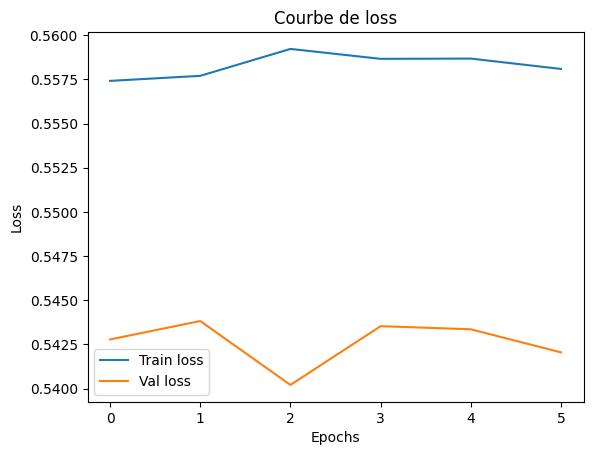

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Courbe de loss")
plt.show()


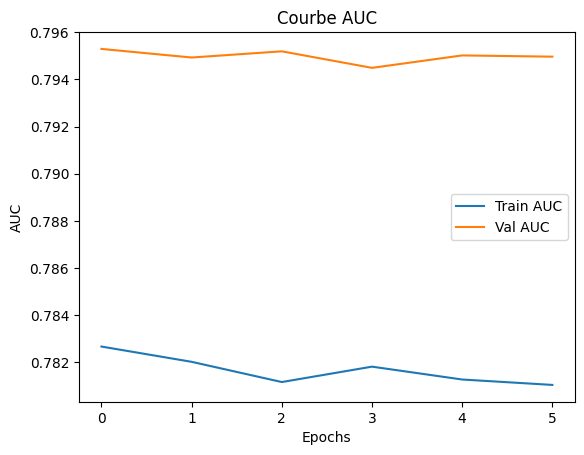

In [ ]:
plt.figure()
plt.plot(history.history["auc"], label="Train AUC")
plt.plot(history.history["val_auc"], label="Val AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.title("Courbe AUC")
plt.show()


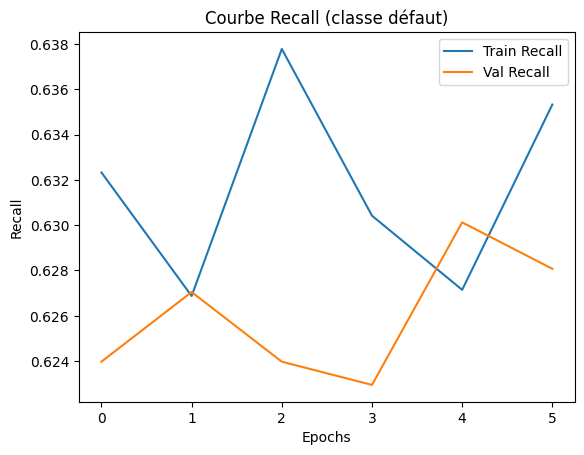

In [ ]:
plt.figure()
plt.plot(history.history["recall"], label="Train Recall")
plt.plot(history.history["val_recall"], label="Val Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.title("Courbe Recall (classe défaut)")
plt.show()


⚠️ Le seuil de décision du MLP a été fixé à 0.3 afin de privilégier la détection des défauts, conformément aux objectifs métiers.  
Les autres modèles utilisent un seuil standard de 0.5 afin de garantir une comparaison équitable.


In [ ]:
y_prob = best_model.predict(X_test_scaled).ravel()

# Seuil métier (ajustable)
threshold = 0.3
y_pred = (y_prob > threshold).astype(int)


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


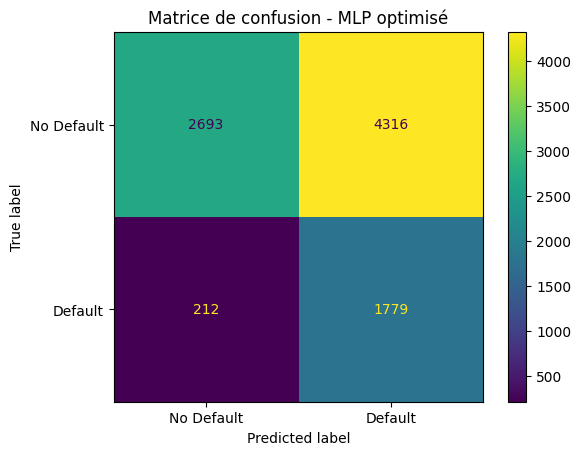

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Default", "Default"]
)

disp.plot()
plt.title("Matrice de confusion - MLP optimisé")
plt.show()


### Évaluation du MLP

L’évaluation du modèle MLP est réalisée sur le jeu de test uniquement.
Les performances sont mesurées à l’aide :
- du rapport de classification (précision, rappel, F1-score),
- du score ROC-AUC.

Une attention particulière est portée au rappel de la classe défaut, qui est un critère clé
dans un contexte de gestion du risque bancaire.


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC-AUC :", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.93      0.38      0.54      7009
           1       0.29      0.89      0.44      1991

    accuracy                           0.50      9000
   macro avg       0.61      0.64      0.49      9000
weighted avg       0.79      0.50      0.52      9000

ROC-AUC : 0.7732209337796945


## Modèle KNN (K-Nearest Neighbors)

Le modèle KNN est un algorithme de classification basé sur la proximité entre les observations.
Chaque instance est classée selon la majorité des classes de ses k plus proches voisins.

Le modèle KNN est sensible à l’échelle des données, ce qui justifie l’utilisation préalable
d’une normalisation.

Une recherche de paramètres a été effectuée afin d’identifier le nombre optimal de voisins (k),
ainsi que la métrique de distance utilisée.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [5, 7, 9, 11, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}



In [ ]:
grid_knn = GridSearchCV(
    knn,
    param_grid,
    scoring="recall",   # recall de la classe 1
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_knn.fit(X_train_scaled, y_train)

print("Meilleurs paramètres KNN :", grid_knn.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres KNN : {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
knn_best = grid_knn.best_estimator_

# Probabilités
y_prob_knn = knn_best.predict_proba(X_test_scaled)[:, 1]

# Prédictions (seuil standard)
y_pred_knn = (y_prob_knn > 0.5).astype(int)
print("ROC-AUC KNN :", roc_auc_score(y_test, y_prob_knn))


ROC-AUC KNN : 0.7114784757976739


### Évaluation du KNN

Les performances du KNN sont évaluées à l’aide du rapport de classification et du score ROC-AUC.
Les résultats montrent que le modèle identifie correctement les clients non défaillants,
mais présente des limitations dans la détection des clients à risque.


In [ ]:
print("=== Classification Report KNN ===")
print(classification_report(y_test, y_pred_knn))


=== Classification Report KNN ===
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      7009
           1       0.53      0.36      0.43      1991

    accuracy                           0.79      9000
   macro avg       0.68      0.64      0.65      9000
weighted avg       0.77      0.79      0.77      9000



## Modèle SVM (Support Vector Machine)

Le SVM est un algorithme de classification qui cherche à déterminer une frontière de décision
maximisant la marge entre les classes.

Dans ce notebook, un SVM linéaire est d’abord utilisé afin d’évaluer si une séparation linéaire
des données est suffisante.
Le paramètre class_weight est activé pour compenser le déséquilibre des classes et réduire
le nombre de faux négatifs.


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score


In [ ]:
from sklearn.svm import LinearSVC

svm_linear_fast = LinearSVC(
    class_weight="balanced",
    max_iter=5000,
    random_state=42
)

param_grid = {
    "C": [0.01, 0.1, 1, 10]
}

grid_fast = GridSearchCV(
    svm_linear_fast,
    param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1
)

grid_fast.fit(X_train_scaled, y_train)

print("Meilleur C (LinearSVC) :", grid_fast.best_params_)


Meilleur C (LinearSVC) : {'C': 0.01}


In [ ]:
svm_linear_final = SVC(
    kernel="linear",
    C=0.01,                     # 🔥 trouvé par tuning
    class_weight="balanced",
    probability=True,
    random_state=42
)


In [ ]:
svm_linear_final.fit(X_train_scaled, y_train)

# Probabilités
y_prob_svm_linear = svm_linear_final.predict_proba(X_test_scaled)[:, 1]

# Prédictions (seuil standard)
y_pred_svm_linear = (y_prob_svm_linear > 0.5).astype(int)


In [ ]:
print("=== Classification Report SVM Linéaire ===")
print(classification_report(y_test, y_pred_svm_linear))


from sklearn.metrics import roc_auc_score

print("ROC-AUC SVM Linéaire :", roc_auc_score(y_test, y_prob_svm_linear))



=== Classification Report SVM Linéaire ===
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      7009
           1       0.67      0.28      0.39      1991

    accuracy                           0.81      9000
   macro avg       0.75      0.62      0.64      9000
weighted avg       0.79      0.81      0.78      9000

ROC-AUC SVM Linéaire : 0.744281747532895


In [ ]:
svm_rbf_fast = SVC(
    kernel="rbf",
    class_weight="balanced",
    random_state=42
)


In [ ]:
param_grid_fast = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 0.01]
}


In [ ]:
grid_fast = GridSearchCV(
    svm_rbf_fast,
    param_grid_fast,
    scoring="recall",
    cv=3,          # 🔥 CV réduite
    n_jobs=-1
)

grid_fast.fit(X_train_scaled, y_train)

print("Meilleurs paramètres SVM RBF (fast):", grid_fast.best_params_)


Meilleurs paramètres SVM RBF (fast): {'C': 1, 'gamma': 'scale'}


In [ ]:
svm_rbf_final = SVC(
    kernel="rbf",
    C=grid_fast.best_params_["C"],
    gamma=grid_fast.best_params_["gamma"],
    class_weight="balanced",
    probability=True,   # seulement maintenant
    random_state=42
)

svm_rbf_final.fit(X_train_scaled, y_train)



SVC(C=1, class_weight='balanced', probability=True, random_state=42)

### Évaluation du SVM linéaire

Le modèle SVM est évalué sur le jeu de test à l’aide des mêmes métriques que les autres modèles,
ce qui garantit une comparaison équitable.

Les résultats permettent d’analyser les limites d’un modèle linéaire et de justifier,
si nécessaire, l’utilisation d’un noyau non linéaire.


In [ ]:
y_prob_svm_rbf = svm_rbf_final.predict_proba(X_test_scaled)[:, 1]
y_pred_svm_rbf = (y_prob_svm_rbf > 0.5).astype(int)

print("=== Classification Report SVM RBF ===")
print(classification_report(y_test, y_pred_svm_rbf))

print("ROC-AUC SVM RBF :", roc_auc_score(y_test, y_prob_svm_rbf))


=== Classification Report SVM RBF ===
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      7009
           1       0.58      0.43      0.49      1991

    accuracy                           0.81      9000
   macro avg       0.72      0.67      0.69      9000
weighted avg       0.79      0.81      0.79      9000

ROC-AUC SVM RBF : 0.7571672755678481


## Conclusion intermédiaire

Les trois modèles ont été entraînés et évalués dans des conditions identiques.
Le MLP se distingue par sa capacité à détecter efficacement les cas de défaut,
tandis que le KNN et le SVM linéaire présentent des performances plus limitées
dans ce contexte déséquilibré.
